Resource: https://huggingface.co/learn/cookbook/en/advanced_rag

In [1]:
import datasets
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
from datasets import Dataset
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter

pd.set_option("display.max_columns", None)

In [3]:
from huggingface_hub import interpreter_login
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



# Load Knowledge Base

- The knowledge base contains information that will be queried based on similarity with the user prompt.
- This database can be embedded using an embedding model and vectorized for faster retrieval.
- The database can be formatted in many ways and can contain metadata for more information.

In [4]:
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [5]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

# Retriever - embeddings

- The retriever acts like an internal searchg engine: give the user query, it returns a few relevant snippets from your knowledge base.
- Our objective here is, given a user prompt, find the most relevant snippets from your knowledge base to answer the question.
- `top_k` is a parameter to define how many snippets to retrieve
- The size of the snippets is called `chunk_size`
  - Your `chunk_size` is allowed to vary from one snippet to the other
  - Increasing the `top_k` increases the chance to get relevant elements
  - The summed length of your retrieved documents shouldnt be too high since most current models can take up to 16k tokens before causing *Lost-in-the-middle* phenomenon (https://huggingface.co/papers/2307.03172)

## Split the documents into chunks

- Split the documents into smaller chunk and prepare a collection of semantically relevant snippets
  - Size should be adapted to precise ideas: too small will truncate ideas and too large will dilute them
  - Notebook on chunking: https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb
- Recursive chunking breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split doesn’t give the right size or shape of chunks, the method repeats itself on the new chunks using a different separator. For instance with the list of separators `["\n\n", "\n", ".", ""]`:
  - The method will first break down the document wherever there is a double line break `"\n\n"`.
  - Resulting documents will be split again on simple line breaks `"\n"`, then on sentence ends `"."`.
  - Finally, if some chunks are still too big, they will be split whenever they overflow the maximum size.
  - Chunk visualizer: https://huggingface.co/spaces/m-ric/chunk_visualizer

In [6]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100, # The number of characters to overlap between chunks
    add_start_index=True, # If `True`, includes chunk's start index in metadata
    strip_whitespace=True, # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS
)

In [8]:
docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

- Keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length `max_seq_length`
- We need to make sure that our chunk size is below this limit to prevent truncating before processing, resulting in losing relevancy

In [9]:
from sentence_transformers import SentenceTransformer

print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

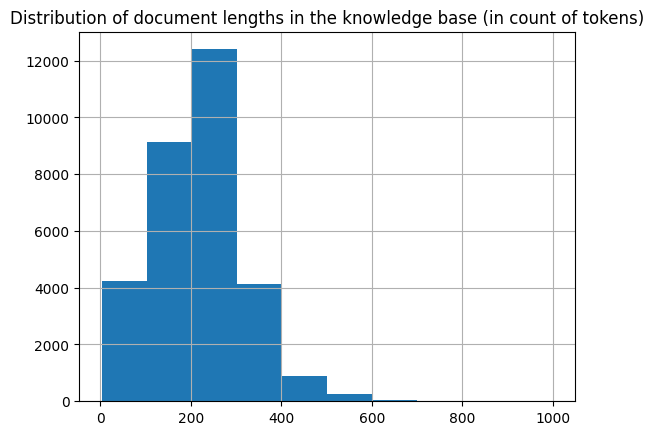

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

Model's maximum sequence length: 512 so the chunk lengths are not aligned with our limit of 512 tokens, and some documents are above the limit, thus some part of them will be lost in truncation!

- We will change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters
- Then we can choose a specific chunk size, here we would choose a lower threshold than 512
  - Smaller documents could allow the split to focus on more specific ideas
  - Too small chunks would split sentences in half, thus loosing meaning again

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

  0%|          | 0/17995 [00:00<?, ?it/s]

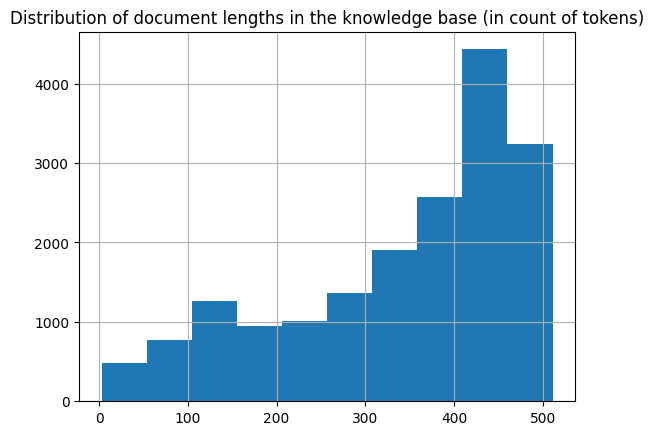

In [12]:
# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

## Building the vector database

- How does retrieval work?
  - Once all the chunks are embedded, we store them in a vector database
  - It gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database
  - The technical challenge is thus, given a query vector, to quickly find the nearest neighbors of this vector in the vector database.
- We need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.
  - Nearest Neighbor search algorithm
  - Distances
    - Cosine similarity
    - Dot product
    - Euclidean distance

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)